In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os

import joblib
from skimage.io import imread

In [ ]:
#testing clustering on a single image
'''
from sklearn.cluster import KMeans

#img = X[1]
img = imread(os.path.join(os.path.join(data_path, "3956271103.jpg")))
img=cv2.resize(img,(240,180))
img_convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img/255.0
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

kmeans=KMeans(n_clusters=3,random_state=0).fit(vectorized)
vectorized2=vectorized.copy()
for i in np.unique(kmeans.labels_):
    vectorized2[kmeans.labels_==i,:]=kmeans.cluster_centers_[i]
vectorized2=vectorized2.reshape(img.shape)

plt.imshow(vectorized2)
'''

In [2]:
from sklearn.cluster import KMeans
import cv2

# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10

def cluster_img_colors(path, labels, K, attempts, criteria):
    data={}
    data['label']=[]
    data['filename']=[]
    data['data']=[]
    
    pklname= f"leaf_images_cluster_1500k"+str(K)+".pkl"
    
    image_counter={0:0,1:0,2:0,3:0,4:0}
    images_done=0
    
    for file in os.listdir(path):
        #to get equal number of labeled files
        if image_counter[int(labels[file])]==300:
            continue
        else:
            image_counter[int(labels[file])]+=1
        img = imread(os.path.join(os.path.join(path, file)))
        img=cv2.resize(img,(240,180))
        img_convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        vectorized = img.reshape((-1,3))
        vectorized = np.float32(vectorized)
        kmeans=KMeans(n_clusters=K,random_state=0).fit(vectorized)
        vectorized2=vectorized.copy()
        for i in np.unique(kmeans.labels_):
            vectorized2[kmeans.labels_==i,:]=kmeans.cluster_centers_[i]
        vectorized2=vectorized2.reshape(img.shape)
        #plt.imshow(vectorized2)
        data['label'].append(int(labels[file]))
        data['filename'].append(file)
        data['data'].append(vectorized2)
        images_done+=1
        if images_done%50==0:
            print('images_done: ',images_done)
        if image_counter[0]+image_counter[1]+image_counter[2]+image_counter[3]+image_counter[4]==1500:
            #if images_done%10000==0:
            break
        
    joblib.dump(data, pklname)


In [3]:
data_path = fr'{os.getenv("HOME")}/kaggle/unsupervised_learning_cassava_leaf_disease/train_images'
#os.listdir(data_path)

labels_file=open('train.csv')
labels_dict={}
for line in labels_file:
    line=line.strip().split(',')
    labels_dict[line[0]]=line[1]
    

In [4]:
cluster_img_colors(data_path, labels_dict, K, attempts, criteria)

images_done:  50
images_done:  100
images_done:  150
images_done:  200
images_done:  250
images_done:  300
images_done:  350
images_done:  400
images_done:  450
images_done:  500
images_done:  550
images_done:  600
images_done:  650
images_done:  700
images_done:  750
images_done:  800
images_done:  850
images_done:  900
images_done:  950
images_done:  1000
images_done:  1050
images_done:  1100
images_done:  1150
images_done:  1200
images_done:  1250
images_done:  1300
images_done:  1350
images_done:  1400
images_done:  1450
images_done:  1500


In [5]:
from collections import Counter
 
data = joblib.load(f"leaf_images_cluster_1500k3.pkl")
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

print(data['data'][0].shape, K)


number of samples:  1500
keys:  ['label', 'filename', 'data']
image shape:  (180, 240, 3)
labels: [0 1 2 3 4]
(180, 240, 3) 3


In [6]:
X = np.array(data['data'])
y = np.array(data['label'])

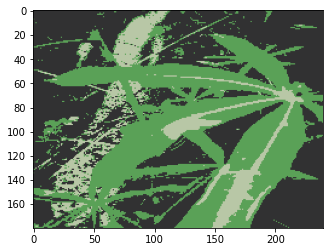

In [7]:
#show image to make sure clustering is working
plt.imshow(X[7])

In [9]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X.astype('float32'), 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y,
)

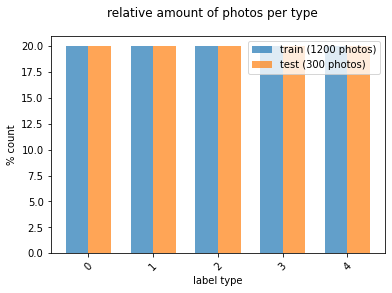

In [10]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('label type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes=5

model1=Sequential()
model1.add(Conv2D(32,(3,3),padding='same',input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32,(3,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64,(3,3),padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64,(3,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 240, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 240, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 178, 238, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 178, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 119, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 119, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 89, 119, 64)       1

In [13]:
batch_size=32
opt_2=keras.optimizers.RMSprop(learning_rate=0.0005)
model1.compile(loss='sparse_categorical_crossentropy',optimizer=opt_2,metrics=['accuracy'])
model1.fit(X_train,y_train,batch_size=batch_size,epochs=5,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/5
38/38 [==============================] - 65s 2s/step - loss: 0.5497 - accuracy: 0.8967 - val_loss: 2.6611 - val_accuracy: 0.2967
Epoch 2/5
38/38 [==============================] - 67s 2s/step - loss: 0.1318 - accuracy: 0.9592 - val_loss: 6.2667 - val_accuracy: 0.2667
Epoch 3/5
38/38 [==============================] - 69s 2s/step - loss: 0.1676 - accuracy: 0.9558 - val_loss: 2.5568 - val_accuracy: 0.2900
Epoch 4/5
38/38 [==============================] - 70s 2s/step - loss: 0.0381 - accuracy: 0.9900 - val_loss: 3.3200 - val_accuracy: 0.2667
Epoch 5/5
38/38 [==============================] - 70s 2s/step - loss: 0.1592 - accuracy: 0.9742 - val_loss: 4.3109 - val_accuracy: 0.2767


In [16]:
y_pred=model1.predict(X_test)
y_pred=y_pred.argmax(axis=1)
print(y_pred)
#y_pred = np.argmax(y_pred,axis=-1)
#label = np.argmax(y_pred,axis=-1)
#print(label)


AttributeError: 'numpy.ndarray' object has no attribute 'mode'

In [15]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr=classification_report(y_test,y_pred)
print(cr)

score_df=pd.DataFrame({'accuracy':accuracy_score(y_test,y_pred),
                      'precision':precision_score(y_test,y_pred,average='micro'),
                      'recall':recall_score(y_test,y_pred,average='micro'),
                      'f1':f1_score(y_test,y_pred,average='micro')},
                     index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

           0       0.45      0.17      0.24        60
           1       0.37      0.28      0.32        60
           2       0.23      0.78      0.36        60
           3       0.28      0.08      0.13        60
           4       0.36      0.07      0.11        60

    accuracy                           0.28       300
   macro avg       0.34      0.28      0.23       300
weighted avg       0.34      0.28      0.23       300

   accuracy  precision    recall        f1
0  0.276667   0.276667  0.276667  0.276667


In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
sns.set_context('talk')
cm=confusion_matrix(y_test,y_pred,normalize='true')
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4])
disp.plot()
plt.show()